# Vivian Yeh – Final Project: Aircraft Type Recognition

**Objective**:

The objective is to develop a machine learning model that can accurately classify images of military aircraft into their respective types.

The model should be able to distinguish between the 43 different types of military aircraft (A-10, A-400M, AG-600, AV-8B, B-1, B-2, B-52 Be-200, C-130, C-17, C-2, C-5, E-2, E-7, EF-2000, F-117, F-14, F-15, F-16, F/A-18, F-22, F-35, F-4, J-20, JAS-39, MQ-9, Mig-31, Mirage2000, P-3, RQ-4, Rafale, SR-71(may contain A-12), Su-34, Su-57, Tornado, Tu-160, Tu-95(Tu-142), U-2, US-2(US-1A Kai), V-22, Vulcan, XB-70, YF-23).

**Problem Statement**:

Aircraft type recognition plays a crucial role in various applications, including airport surveillance, aircraft maintenance, and air traffic control. The manual identification of aircraft types from images can be time-consuming and prone to errors. Therefore, the task is to build a machine learning model that can automate the process and accurately classify military aircraft types based on input images.

The model should take an image of an aircraft as input and output the predicted aircraft type. The problem requires the classification of multiple aircraft types, which makes it a multi-class classification problem.

The model's performance will be evaluated based on metrics such as accuracy, precision, recall, and F1 score. The goal is to develop a robust and accurate model that can correctly classify aircraft types in real-time scenarios, even in the presence of variations in lighting conditions, angles, and backgrounds.

The solution to this problem will provide significant benefits to the military by reducing the time and effort required to identify aircraft types, enabling faster decision-making, and enhancing situational awareness. It can assist in tasks such as intelligence gathering, target recognition, and monitoring airspace activities.

The successful development of an accurate and robust machine learning model for military aircraft type recognition will have practical applications in military operations, defense systems, and aviation security.

## Import Necessary Libraries

In [1]:
# %pip install --upgrade pip
# %pip install tensorflow

import os, glob
import cv2
import time
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from fastai.vision.all import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Preprocessing & EDA

### Load data

Military Aircraft Detection Dataset: https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset?resource=download


In [3]:
train_set = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab_Notebooks/ML/military_aircraft_detection_dataset/types',
    image_size = (256, 256),
    validation_split = 0.3,
    subset = "training",
    shuffle = True,
    batch_size = 32,
    seed = 2023)

validation_set = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab_Notebooks/ML/military_aircraft_detection_dataset/types',
    image_size = (256, 256),
    validation_split = 0.35,
    subset = "validation",
    shuffle = True,
    batch_size = 32,
    seed = 2023)

Found 18027 files belonging to 43 classes.
Using 12619 files for training.
Found 18027 files belonging to 43 classes.
Using 6309 files for validation.


In [4]:
# Calculate total number of batches in the validation set
validation_batches = tf.data.experimental.cardinality(validation_set)

# Create test set by taking a fraction of the validation set
test_set = validation_set.take(validation_batches // 5)

# Modify the validation set by excluding the batches used for the test set
validation_set = validation_set.skip(validation_batches // 5)

> The `test_set` is created by taking a fraction of the batches from the beginning of the `validation_set`, while the modified `validation_set` excludes those batches. By splitting the `validation_set` into a test set and a reduced validation set, we will be able to evaluate the model's performance on unseen data (test set) while still having a separate subset of data (validation set) for validation during training.

In [ ]:
train_set, validation_set, test_set

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [5]:
test_percentage = len(test_set) / len(validation_set) * 100
print(f"The test set represents {test_percentage:.2f}% of the validation set.")

The test set represents 24.53% of the validation set.


In [ ]:
train_set_size = len(train_set)
validation_set_size = len(validation_set)
test_set_size = len(test_set)

print(f"There are {train_set_size} images in the training set.")
print(f"There are {validation_set_size} images in the validation set.")
print(f"There are {test_set_size} images in the test set.")

There are 395 images in the training set.
There are 159 images in the validation set.
There are 39 images in the test set.


### Display data sample

In [ ]:
class_names = np.array(train_set.class_names)
class_names

array(['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200',
       'C130', 'C17', 'C2', 'C5', 'E2', 'E7', 'EF2000', 'F117', 'F14',
       'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'MQ9',
       'Mig31', 'Mirage2000', 'P3', 'RQ4', 'Rafale', 'SR71', 'Su34',
       'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan',
       'XB70', 'YF23'], dtype='<U10')

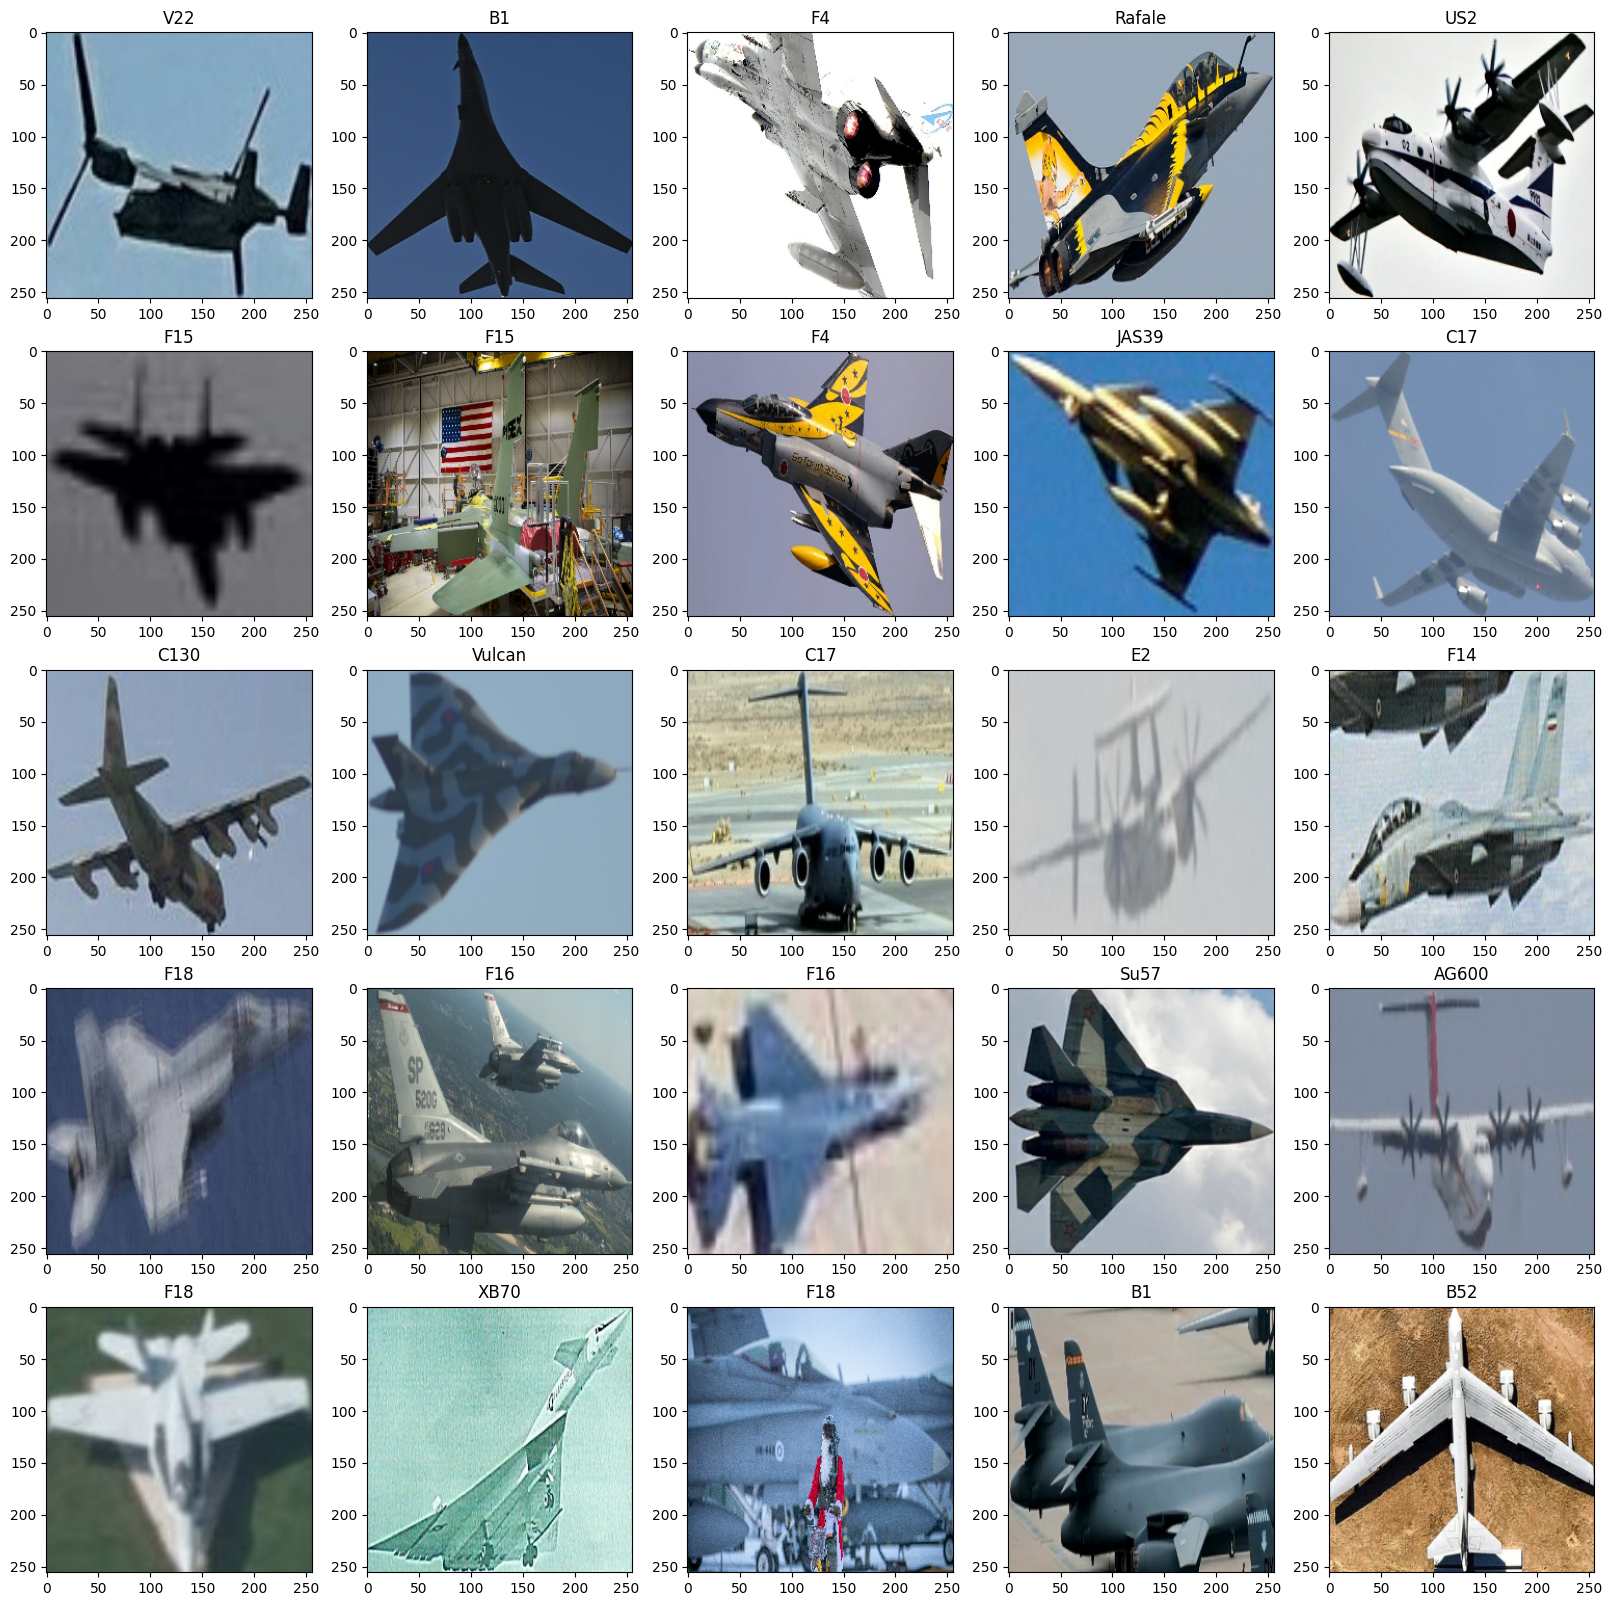

In [ ]:
classes = train_set.class_names

plt.figure(figsize = (20, 20))
for images, labels in train_set.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])

### Visualize train set

In [ ]:
class_labels = []
for images, labels in train_set:
    class_labels.extend(labels.numpy())

# Count images associated with each aircraft type in the train set
class_names = train_set.class_names
class_counts = np.bincount(class_labels)

for i, count in enumerate(class_counts):
    class_name = class_names[i]
    print(f"Class: {class_name}, Count: {count}")

Class: A10, Count: 370
Class: A400M, Count: 229
Class: AG600, Count: 122
Class: AV8B, Count: 250
Class: B1, Count: 346
Class: B2, Count: 291
Class: B52, Count: 304
Class: Be200, Count: 173
Class: C130, Count: 535
Class: C17, Count: 315
Class: C2, Count: 415
Class: C5, Count: 213
Class: E2, Count: 259
Class: E7, Count: 80
Class: EF2000, Count: 342
Class: F117, Count: 216
Class: F14, Count: 297
Class: F15, Count: 724
Class: F16, Count: 740
Class: F18, Count: 710
Class: F22, Count: 368
Class: F35, Count: 629
Class: F4, Count: 366
Class: J20, Count: 298
Class: JAS39, Count: 287
Class: MQ9, Count: 192
Class: Mig31, Count: 207
Class: Mirage2000, Count: 249
Class: P3, Count: 68
Class: RQ4, Count: 188
Class: Rafale, Count: 306
Class: SR71, Count: 158
Class: Su34, Count: 178
Class: Su57, Count: 190
Class: Tornado, Count: 241
Class: Tu160, Count: 169
Class: Tu95, Count: 162
Class: U2, Count: 154
Class: US2, Count: 383
Class: V22, Count: 492
Class: Vulcan, Count: 204
Class: XB70, Count: 107
Class

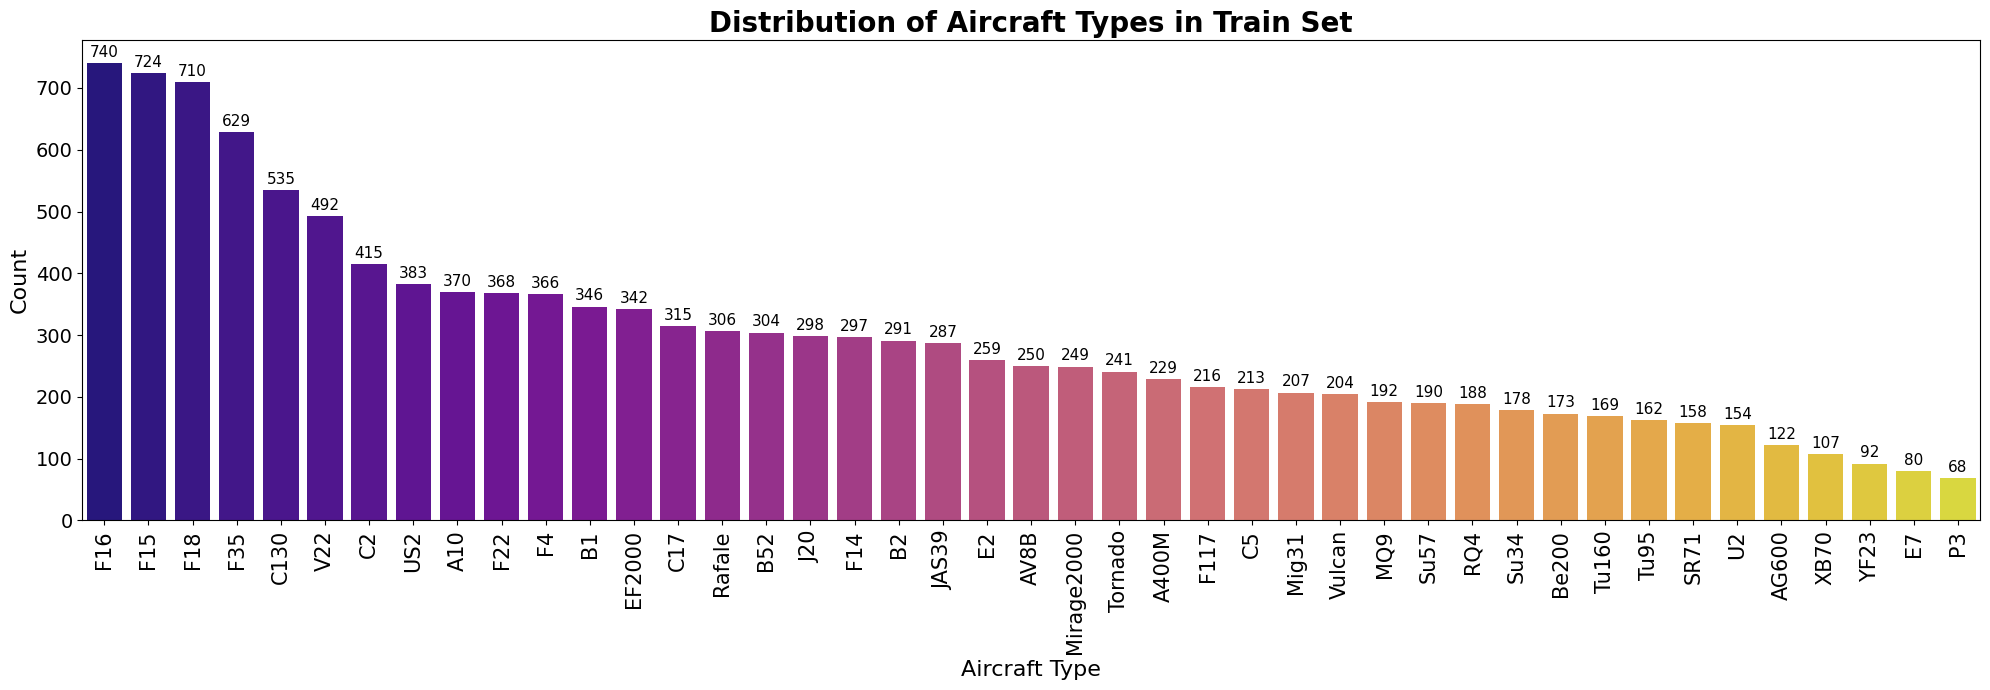

In [ ]:
value_counts = dict(zip(class_names, class_counts))
sorted_counts = sorted(value_counts.items(), key = lambda x: x[1], reverse = True)

labels = [item[0] for item in sorted_counts]
counts = [item[1] for item in sorted_counts]

plt.figure(figsize = (20, 7))
sns.barplot(x = labels, y = counts, palette = 'plasma')

plt.title('Distribution of Aircraft Types in Train Set', fontsize = 20, fontweight = 'bold')
plt.xlabel('Aircraft Type', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks(fontsize = 14)

# Add count values above each bar
for i, value in enumerate(counts):
    plt.text(i, value + 10, str(value), fontsize = 11, ha = 'center')

plt.tight_layout()
plt.show()

## 2. Build Classifier

> We first prefetch the data to optimize the training and evaluation process by overlapping the data loading and model execution, reducing the potential bottlenecks caused by data loading latency. This technique can help improve the overall training and evaluation performance of the model.

In [ ]:
# Autotune the prefetch buffer size based on available system resources
autotune = tf.data.AUTOTUNE

# Create prefetched datasets
pf_train = train_set.prefetch(buffer_size = autotune)
pf_validation = validation_set.prefetch(buffer_size = autotune)
pf_test = test_set.prefetch(buffer_size = autotune)

> Now we create a Sequential model called `data_augmentation` and add two data augmentation layers: RandomRotation and RandomFlip. Data augmentation is a technique that artificially increases the size of the training dataset by applying random transformations to the input images. This helps the model generalize better and improves its ability to handle variations in the test data.

In [ ]:
# Define the data augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomFlip("horizontal_and_vertical")
])

### Base Model (ResNet50)

> Next, we create a base model using ResNet50, short for Residual Network-50, is a deep CNN architecture and has 50 layers of calculations that help it learn and recognize different patterns in images. ResNet50 has been trained on a large dataset of images (ImageNet) and is very effective in image recognition tasks.

Advantages:

- **Deeper architecture**: ResNet50 has a deep structure with 50 layers, allowing it to learn complex features and patterns in images.

- **Residual connections**: ResNet50 introduced skip connections that help alleviate the vanishing gradient problem and enable training of very deep networks. This improves optimization and performance.

- **Pre-trained weights**: ResNet50 has been trained on a large dataset (ImageNet), giving it learned representations that are effective in capturing visual features. Using these pre-trained weights saves time and resources.

- **Versatility**: ResNet50 performs well in various computer vision tasks, such as image classification, object detection, and image segmentation.

- **State-of-the-art performance**: ResNet50 and its variants have achieved top performance on benchmark datasets and competitions, showcasing its effectiveness in feature extraction and achieving high accuracy.

Whether EfficientNet, VGG, or ResNet is better depends on the specific task, dataset, and available computational resources. Each of these architectures has its strengths and trade-offs, so it's important to consider different factors when choosing a model.

1. **EfficientNet**: EfficientNet is a recent architecture that has gained attention for its remarkable performance and efficiency. It achieves a good balance between accuracy and computational efficiency by scaling the model width, depth, and resolution using a compound scaling method. EfficientNet tends to perform well on various computer vision tasks, especially when there are constraints on computational resources.

2. **VGG**: VGG is a classic deep convolutional neural network architecture known for its simplicity and uniformity. It has a straightforward structure with stacked convolutional layers and pooling layers. VGG models are relatively easy to understand and implement. However, VGG architectures are deeper and have a higher number of parameters compared to other models, which can make them computationally expensive.

3. **ResNet**: ResNet introduced the concept of residual connections or skip connections, which help alleviate the vanishing gradient problem and allow for the training of very deep networks. ResNet models have shown excellent performance and are widely used in various computer vision tasks. They have a more compact structure compared to VGG, making them computationally efficient.

To determine which model is better suited for your specific task, it is recommended to consider the following factors:
- Size of the dataset: If you have a large dataset, models like EfficientNet and ResNet can potentially learn more complex patterns and achieve higher accuracy.
- Computational resources: If you have limited computational resources, EfficientNet or smaller variations of VGG might be more suitable due to their efficiency.
- Task requirements: Different architectures may excel in different tasks. It's important to consider the specific requirements of your task, such as the complexity of the objects to be recognized or the presence of fine-grained details.

In practice, it is often useful to try different architectures and compare their performance on a validation set to determine which one works best for your specific problem. Additionally, you can consider using pre-trained models on large datasets, such as ImageNet, as they can provide a good starting point and offer transfer learning benefits.

In [ ]:
# Basic setup
image_size = (256, 256)
image_shape = image_size + (3,)  # 3 color channels RGB

# Input processing
preprocess_input = applications.resnet50.preprocess_input

# Base model (ResNet50)
base_model = applications.ResNet50(
    input_shape = image_shape,
    include_top = False,  # utilize the lower layers for feature extraction
    weights = 'imagenet'
)

> We freeze the layers of the `base_model` to use the pre-trained features extracted by the `base_model` and only train the newly added layers on top of it.

Benefits:

- Prevent overfitting: Freezing the pre-trained layers can help prevent overfitting, especially when you have limited training data.
- Preserve learned features: The pre-trained layers in the base_model have already learned useful features from a large dataset. Freezing them ensures that these valuable features are preserved and not altered during training.



In [ ]:
# Freeze layers
base_model.trainable = False

> We add layers on top of the base_model. The `global_avg` layer reduces the spatial dimensions of the feature map, and the `output_layer` produces the final class probabilities using the softmax activation function. By doing so, we are creating a classification head that takes the features extracted by the `base_model` and maps them to the corresponding class probabilities.

In [ ]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

### Model

> Then, we define the complete model by specifying the input and output layers.

In [ ]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 43)                88107 

### Model Architecture

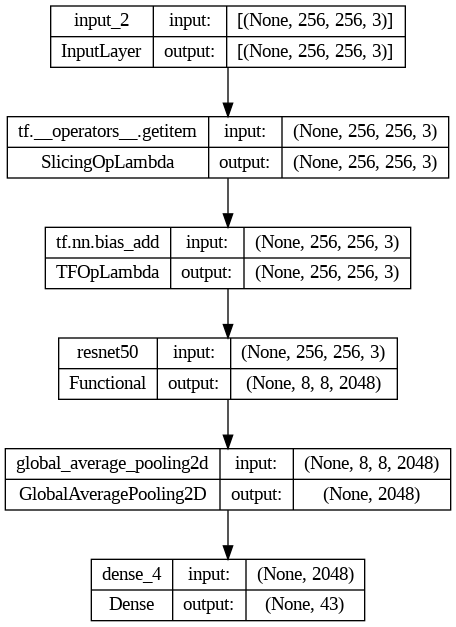

In [ ]:
tf.keras.utils.plot_model(model, "model_architecture.png", show_shapes = True)

In [ ]:
# Compile the model
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))  # learning rate starts at 0.001 and decreases in a cosine-shaped manner over 500 steps
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [ ]:
history = model.fit(pf_train, validation_data = pf_validation, epochs = 3)

Epoch 1/3
395/395 [==============================] - 128s 303ms/step - loss: 2.4291 - accuracy: 0.3661 - val_loss: 1.8475 - val_accuracy: 0.5185
Epoch 2/3
395/395 [==============================] - 115s 289ms/step - loss: 1.5922 - accuracy: 0.6001 - val_loss: 1.8246 - val_accuracy: 0.5297
Epoch 3/3
395/395 [==============================] - 117s 293ms/step - loss: 1.5844 - accuracy: 0.6035 - val_loss: 1.8229 - val_accuracy: 0.5297


### Fine Tuning

> We now fine tune the layers of the `base_model` by selectively freezing the first 100 layers, preventing them from being updated during training. The purpose is to allow the model to fine-tune the later layers while keeping the earlier layers, which have learned more generic features, fixed.


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
# Compile the model again
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics=['accuracy'])

In [ ]:
history_ft = model.fit(pf_train, validation_data = pf_validation, epochs = 13, initial_epoch = history.epoch[-1])  # ensure that the training continues from the last epoch of the previous training history

Epoch 3/13
395/395 [==============================] - 137s 303ms/step - loss: 1.4738 - accuracy: 0.6017 - val_loss: 0.6284 - val_accuracy: 0.8216
Epoch 4/13
395/395 [==============================] - 120s 300ms/step - loss: 0.2360 - accuracy: 0.9500 - val_loss: 0.5443 - val_accuracy: 0.8520
Epoch 5/13
395/395 [==============================] - 129s 323ms/step - loss: 0.2083 - accuracy: 0.9603 - val_loss: 0.5416 - val_accuracy: 0.8518
Epoch 6/13
395/395 [==============================] - 118s 297ms/step - loss: 0.2043 - accuracy: 0.9615 - val_loss: 0.5462 - val_accuracy: 0.8516
Epoch 7/13
395/395 [==============================] - 120s 302ms/step - loss: 0.2084 - accuracy: 0.9602 - val_loss: 0.5456 - val_accuracy: 0.8512
Epoch 8/13
395/395 [==============================] - 127s 320ms/step - loss: 0.2068 - accuracy: 0.9607 - val_loss: 0.5440 - val_accuracy: 0.8522
Epoch 9/13
395/395 [==============================] - 126s 318ms/step - loss: 0.2076 - accuracy: 0.9608 - val_loss: 0.5459 -

## 3. Evaluation

### Loss & Accuracy

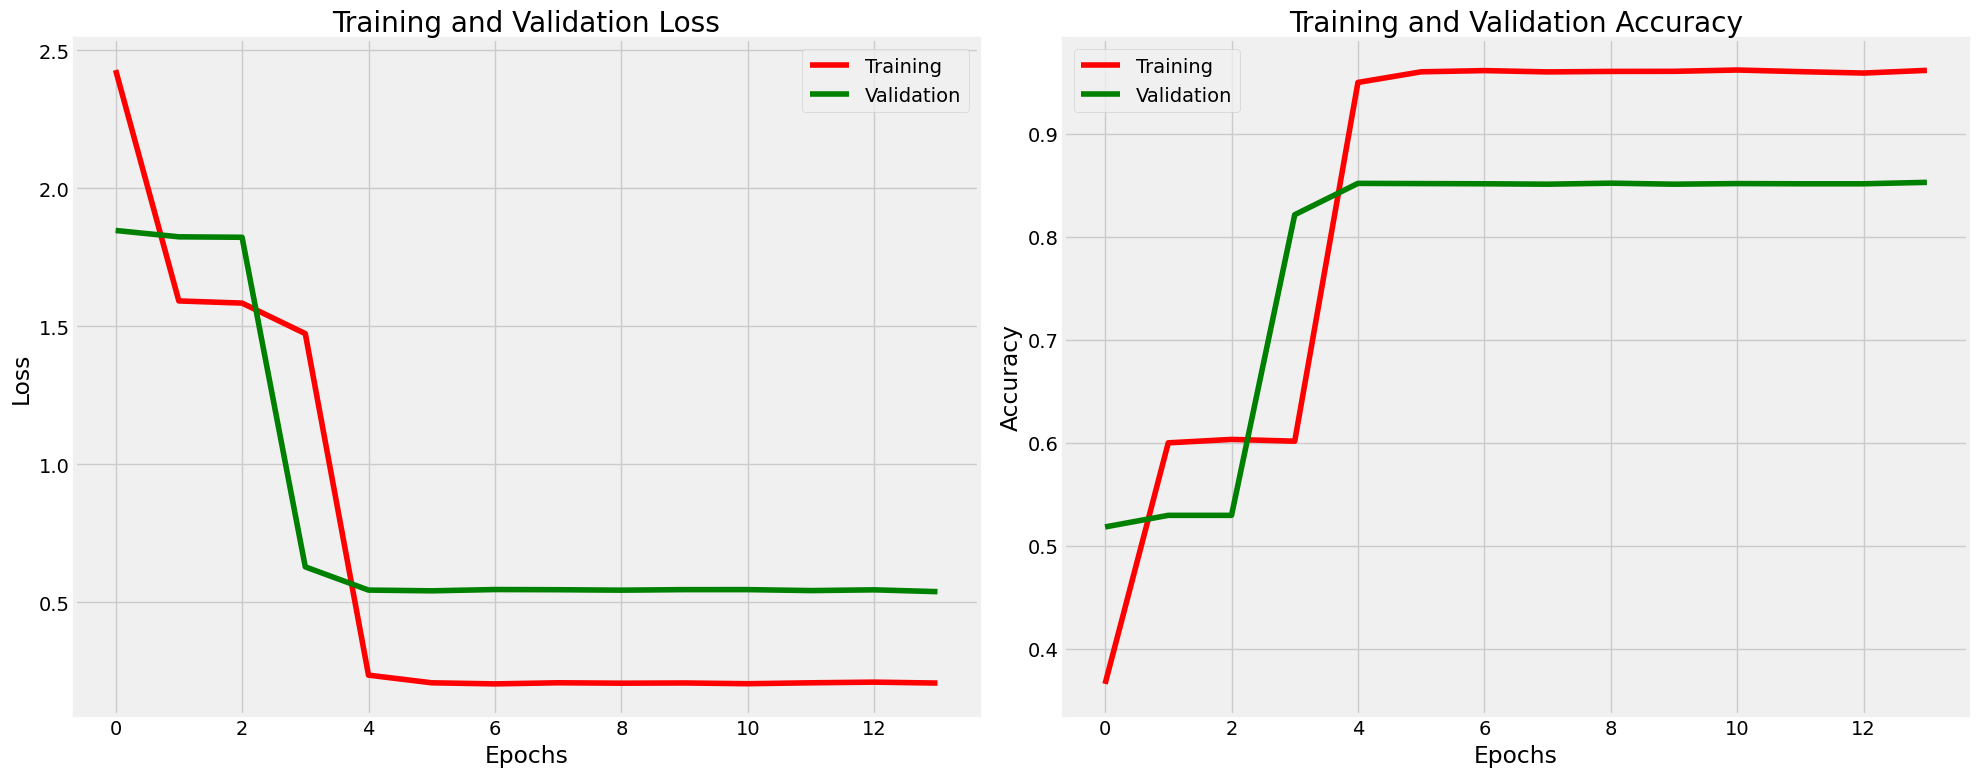

In [ ]:
# Combine the loss and accuracy histories
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']
accuracy = history.history['accuracy'] + history_ft.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history_ft.history['val_accuracy']

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(loss, 'r')
plt.plot(val_loss, 'g')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(accuracy, 'r')
plt.plot(val_accuracy, 'g')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
ts_length = len(test_set)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(pf_train, steps = test_steps, verbose = 1)
valid_score = model.evaluate(pf_validation, steps = test_steps, verbose = 1)
test_score = model.evaluate(pf_test, steps = test_steps, verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 1s/step - loss: 0.2166 - accuracy: 0.9375
Train Loss:  0.2781617045402527
Train Accuracy:  0.90625
--------------------
Validation Loss:  0.8917484283447266
Validation Accuracy:  0.78125
--------------------
Test Loss:  0.2165605127811432
Test Accuracy:  0.9375


### Visualize Test Set Prediction

In [ ]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

1/1 [==============================] - 0s 35ms/step


In [ ]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

[[34 34]
 [38 38]
 [ 1  1]
 [17 17]
 [26 26]
 [27 27]
 [16 16]
 [21 21]
 [27 27]
 [39 39]
 [ 7  7]
 [16 16]
 [14 18]
 [ 4  4]
 [22 22]
 [31 31]
 [22 22]
 [34 34]
 [21 21]
 [21 21]
 [ 3  3]
 [34 34]
 [14 14]
 [39 39]
 [ 6  6]
 [ 8  8]
 [ 9  9]
 [17 17]
 [25 25]
 [ 9  9]
 [21 21]
 [10 10]]


In [ ]:
right_class = []
wrong_class = []

for i, (true_label, pred_label) in enumerate(lab_and_pred):
    if true_label == pred_label:
        right_class.append(i)
    if len(right_class) == 10:
        break

for i, (true_label, pred_label) in enumerate(lab_and_pred):
    if true_label != pred_label:
        wrong_class.append(i)
    if len(wrong_class) == 10:
        break

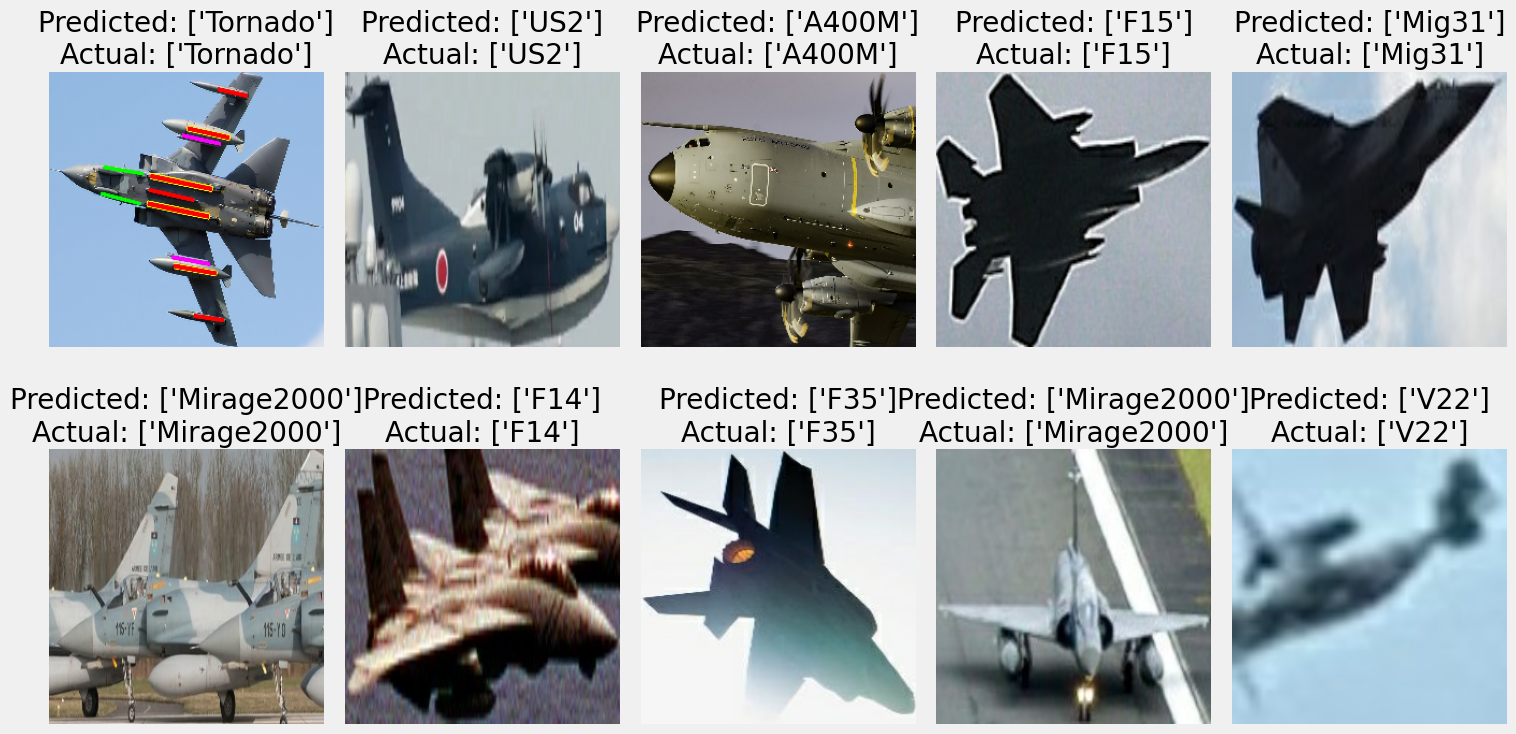

In [ ]:
# Initialize LabelEncoder
labelEncoder = LabelEncoder()

# Fit LabelEncoder on the data
labelEncoder.fit(class_names)

# Horizontal Plot
count = 0
f, ax = plt.subplots(2, 5)
f.set_size_inches(15, 15)

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=-0.8)

for i in range(2):
    for j in range(5):
        image_index = right_class[count]
        predicted_label = pred_labels[image_index]
        true_label = label_batch[image_index]

        # Normalize pixel values
        image = image_batch[image_index]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        ax[i, j].imshow(image)
        ax[i, j].set_title("Predicted: " + str(labelEncoder.inverse_transform([predicted_label])) +
                          "\n" + "Actual: " + str(labelEncoder.inverse_transform([true_label])))
        ax[i, j].axis('off')

        count += 1

plt.tight_layout()
plt.show()


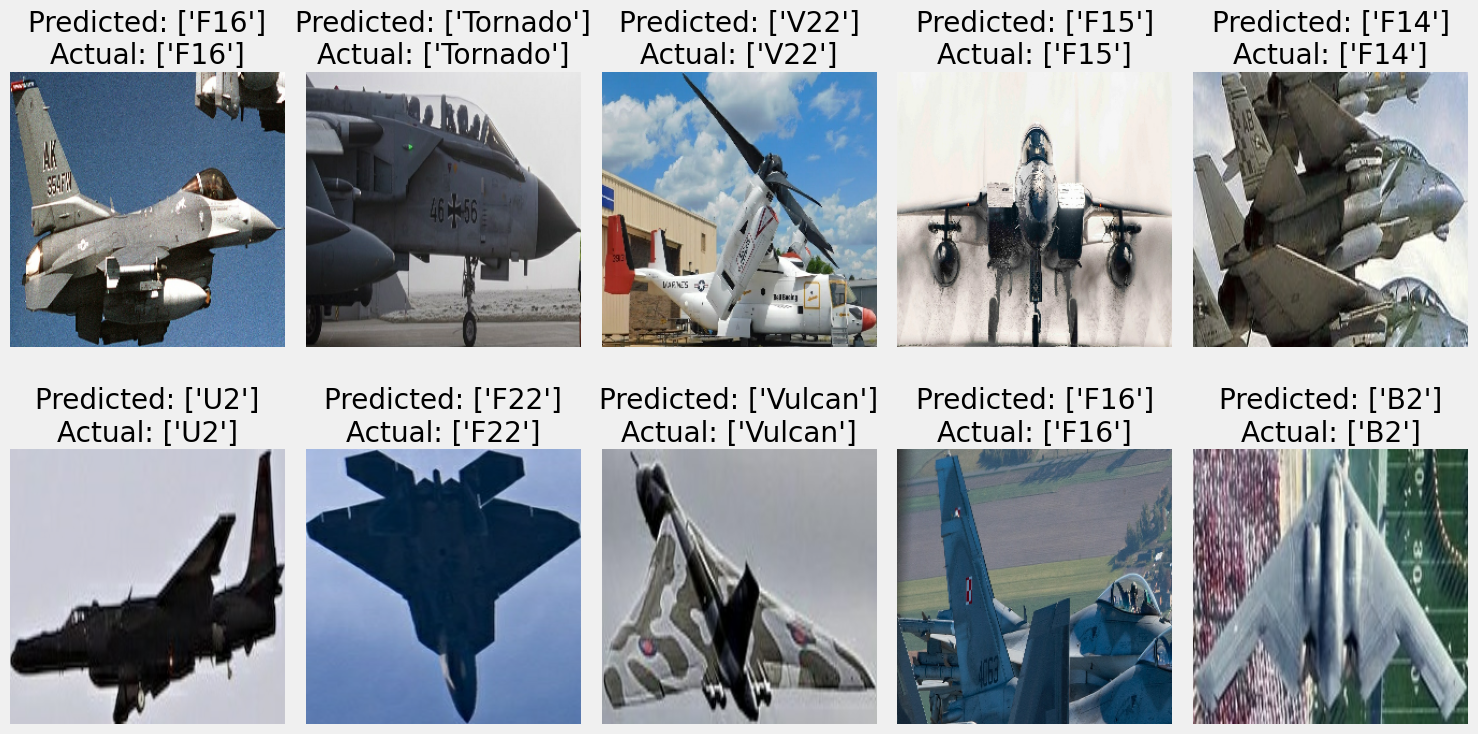

In [ ]:
# Initialize LabelEncoder
labelEncoder = LabelEncoder()

# Fit LabelEncoder on the data
labelEncoder.fit(class_names)

# Horizontal Plot
count = 0
f, ax = plt.subplots(2, 5)
f.set_size_inches(15, 15)

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=-0.8)

for i in range(2):
    for j in range(5):
        image_index = right_class[count]
        predicted_label = pred_labels[image_index]
        true_label = label_batch[image_index]

        # Normalize pixel values
        image = image_batch[image_index]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        ax[i, j].imshow(image)
        ax[i, j].set_title("Predicted: " + str(labelEncoder.inverse_transform([predicted_label])) +
                          "\n" + "Actual: " + str(labelEncoder.inverse_transform([true_label])))
        ax[i, j].axis('off')

        count += 1

plt.tight_layout()
plt.show()


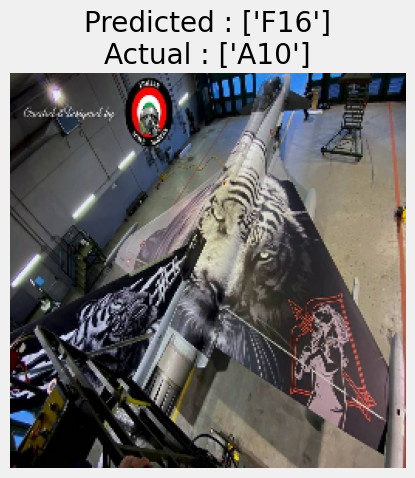

In [ ]:
# Initialize LabelEncoder
labelEncoder = LabelEncoder()

# Fit LabelEncoder on the data
labelEncoder.fit(class_names)

# Plot for the images in wrong_class, if any
count = 0
f, ax = plt.subplots(1, 1)
f.set_size_inches(5, 5)

image_index = wrong_class[0]
predicted_label = pred_labels[image_index]
true_label = np.argmax(label_batch[image_index])

# Normalize pixel values
image = image_batch[image_index]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

ax.imshow(image)
ax.set_title("Predicted : " + str(labelEncoder.inverse_transform([predicted_label])) +
             "\n" + "Actual : " + str(labelEncoder.inverse_transform([true_label])))
ax.axis('off')

plt.tight_layout()
plt.show()

### Confusion Matrix & Classification Report

In [ ]:
path = Path('/content/drive/MyDrive/Colab_Notebooks/ML/military_aircraft_detection_dataset/types')

# Load and prepare the data
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.35, seed = 2023),
    get_y = parent_label,
    item_tfms = [Resize(256, method = 'squish')]
).dataloaders(path)

In [ ]:
# Create the vision learner
learn = cnn_learner(dls, resnet50, metrics = [accuracy])
learn.fine_tune(8)

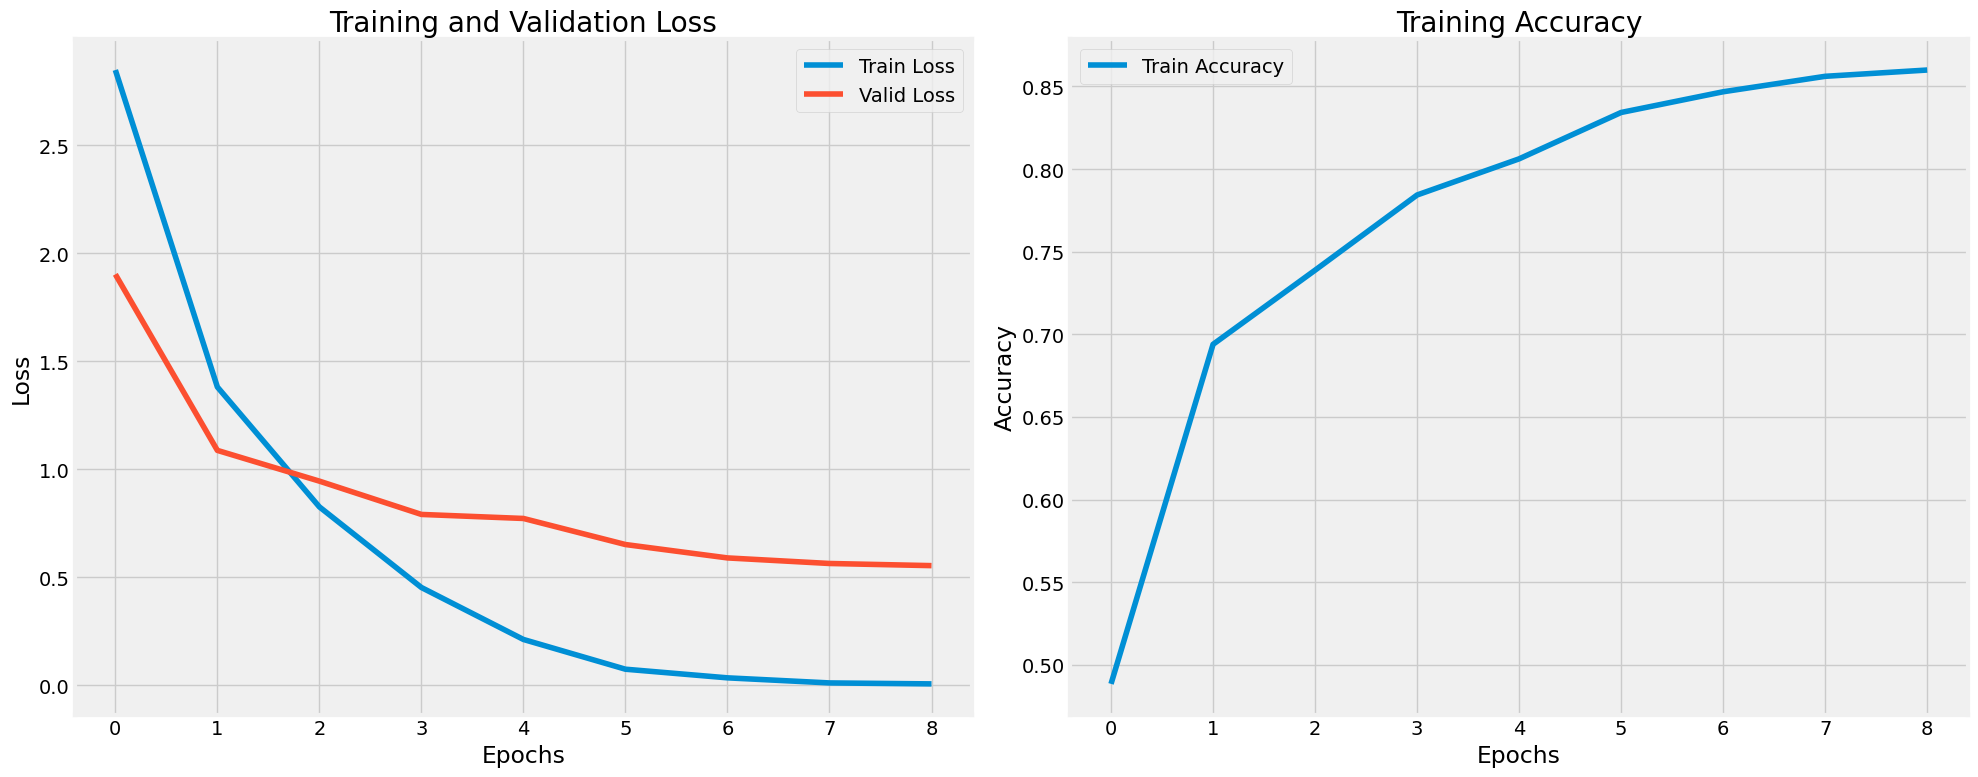

In [ ]:
# Define the epochs and corresponding loss and accuracy values
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_loss = [2.848322, 1.381342, 0.826431, 0.453324, 0.212785, 0.075136, 0.035182, 0.011635, 0.007184]
valid_loss = [1.902769, 1.087902, 0.945601, 0.791468, 0.772817, 0.652181, 0.590208, 0.564437, 0.554510]
accuracy = [0.488508, 0.693929, 0.738786, 0.784276, 0.806150, 0.834205, 0.846727, 0.856079, 0.859883]

# Plot the training and validation loss
plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label = 'Train Loss')
plt.plot(epochs, valid_loss, label = 'Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label = 'Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

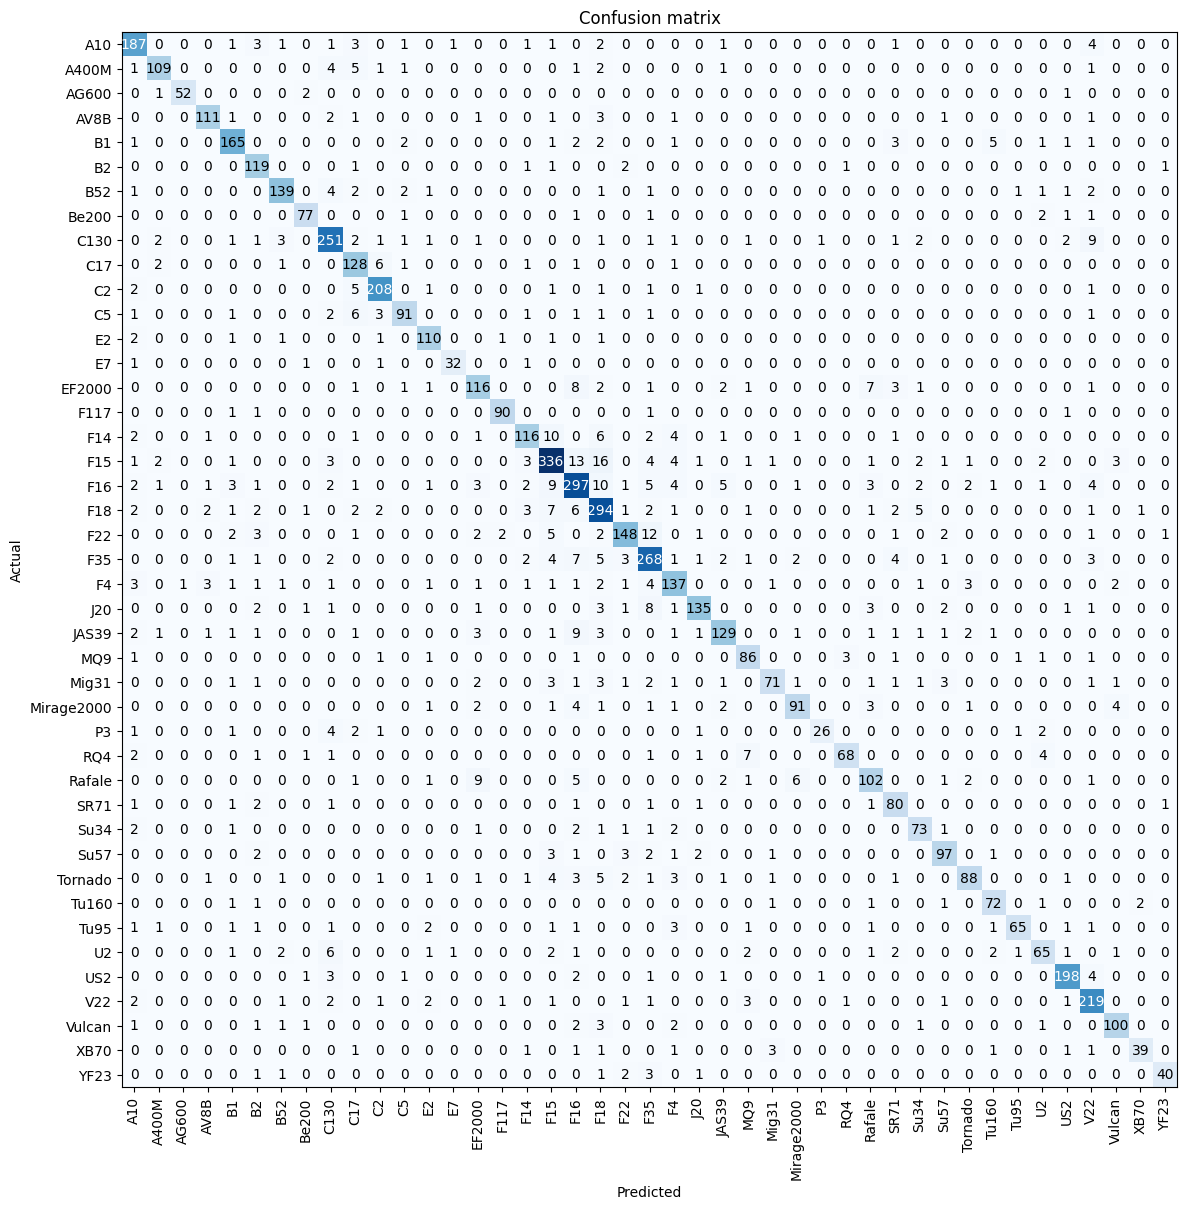

In [ ]:
# Generate the confusion matrix plot
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize = (12, 12))

In [ ]:
# Generate predictions on the validation set
preds, targets = learn.get_preds(ds_idx = 1)

# Convert the predictions and targets to numpy arrays
preds = preds.argmax(dim = 1).numpy()
targets = targets.numpy()

# Generate the classification report
report = classification_report(targets, preds, target_names = class_names)
print(report)

              precision    recall  f1-score   support

         A10       0.85      0.90      0.88       208
       A400M       0.92      0.87      0.89       126
       AG600       0.98      0.93      0.95        56
        AV8B       0.93      0.90      0.91       123
          B1       0.88      0.89      0.88       185
          B2       0.82      0.94      0.88       126
         B52       0.91      0.89      0.90       156
       Be200       0.91      0.92      0.91        84
        C130       0.86      0.89      0.87       283
         C17       0.78      0.91      0.84       141
          C2       0.92      0.94      0.93       221
          C5       0.89      0.83      0.86       109
          E2       0.88      0.93      0.91       118
          E7       0.94      0.89      0.91        36
      EF2000       0.81      0.80      0.80       145
        F117       0.96      0.96      0.96        94
         F14       0.87      0.79      0.83       146
         F15       0.85    

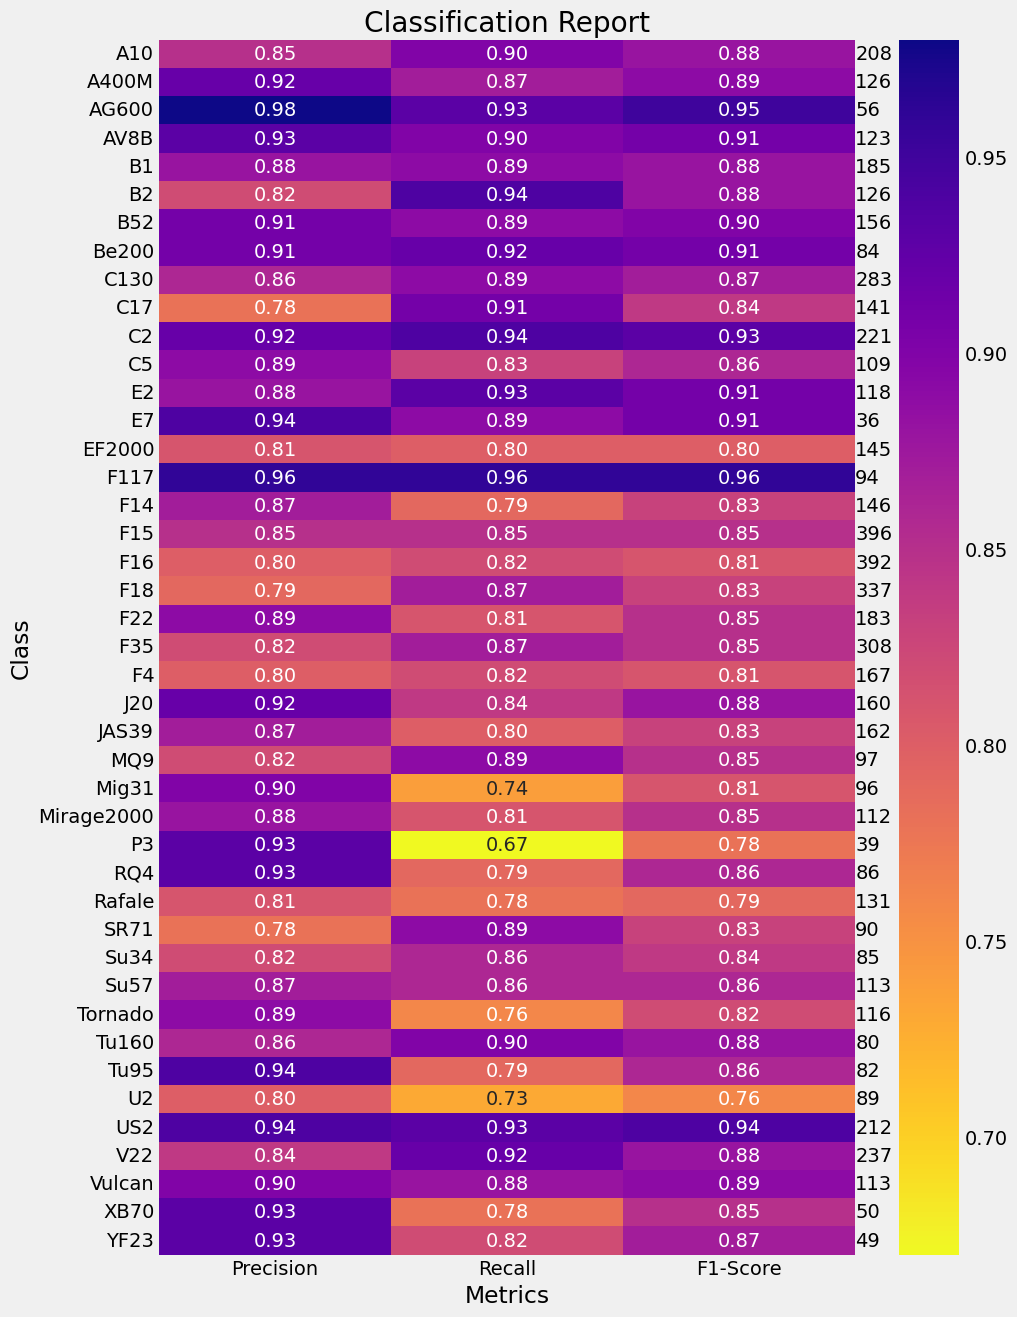

In [ ]:
# Create a pandas DataFrame from the classification report data
data = {'Class': class_names, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score, 'Support': support}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 15))
heatmap = sns.heatmap(df.set_index('Class')[['Precision', 'Recall', 'F1-Score']], annot=True, cmap='plasma_r', fmt=".2f")
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.title('Classification Report')

# Add support values as annotations
for i in range(len(class_names)):
    plt.text(3, i + 0.5, df['Support'][i], va='center')

plt.show()


Looking at the report, we can make the following observations:

1. **Precision**: Precision measures the accuracy of the positive predictions for a class. Classes with high precision scores indicate that the model has a low false positive rate. In this report, classes like AG600, E7, and F117 have high precision scores, indicating that the model performs well in correctly identifying these classes.

2. **Recall**: Recall measures the ability of the model to find all the positive instances of a class. Classes with high recall scores indicate that the model has a low false negative rate. In this report, classes like AG600, C2, and F117 have high recall scores, indicating that the model is good at capturing most of the positive instances for these classes.

3. **F1-Score**: F1-score is the harmonic mean of precision and recall. It provides a balanced measure of both metrics. Classes with high F1-scores indicate that the model has a good balance between precision and recall. In this report, classes like AG600, F117, and US2 have high F1-scores, indicating that the model performs well overall for these classes.

4. **Support**: Support refers to the number of instances of each class in the dataset. It provides an indication of the imbalance or distribution of the classes. In this report, the support varies across classes, ranging from 36 to 396 instances. Classes with low support may have a higher potential for imbalanced training and evaluation.